In [1]:
import os
import matplotlib.pyplot as plt
from utils import json_load

### 1. get labels and pred_scores 
- include small_3 and ada002

In [2]:
# get evaluator result
MODEL_NAME = 'text-embedding-3-small'  # "text-embedding-ada-002"
model_base_name = '-'.join(MODEL_NAME.split('-')[-2:])
response_model = '2_llama_zh' # '4_gemma'

small_3_dir = os.path.join('data', 'deliverables', f"{model_base_name}_semantic_similarity")
small_3_file_path = os.path.join(small_3_dir, f'{response_model}_semantic_result.json')

small_3_data  = json_load(small_3_file_path)
print(len(small_3_data))
small_3_data['1']

load data from: data/deliverables/3-small_semantic_similarity/2_llama_zh_semantic_result.json
80


{'reference_answer': '常見針灸配穴法中,所指的「四關穴」,為下列何穴位之組合?',
 'reference_context': '1.常見針灸配穴法中，所指的「四關穴」，為下列何穴位之組合？\n\xa0\nA.上星、日月\nB.合谷、太衝\nC.內關、外關\nD.上關、下關',
 'response': '台九気终飯加度泩。吃的“六南分。，是一条有分题不别的宽器。',
 'semantic_score': 0.23564175715693894}

In [3]:
# get ada result
ADA_MODEL_NAME = "text-embedding-ada-002"
model_base_name = '-'.join(ADA_MODEL_NAME.split('-')[-2:])

ada_dir = os.path.join('data', 'deliverables', f"{model_base_name}_semantic_similarity")
ada_file_path = os.path.join(ada_dir, f'{response_model}_semantic_result.json')

ada_data  = json_load(ada_file_path)
print(len(ada_data))
ada_data['1']

load data from: data/deliverables/ada-002_semantic_similarity/2_llama_zh_semantic_result.json
80


{'reference_answer': '常見針灸配穴法中,所指的「四關穴」,為下列何穴位之組合?',
 'reference_context': '1.常見針灸配穴法中，所指的「四關穴」，為下列何穴位之組合？\n\xa0\nA.上星、日月\nB.合谷、太衝\nC.內關、外關\nD.上關、下關',
 'response': '台九気终飯加度泩。吃的“六南分。，是一条有分题不别的宽器。',
 'semantic_score': 0.776408433921812}

In [4]:
# get exact match data
dataset_dir = os.path.join('data', 'source', 'normalized_exact_match_result')
label_file_path = os.path.join(dataset_dir, f'{response_model}_evaluation_result.json')
label_data = json_load(label_file_path)
label_data[0]

load data from: data/source/normalized_exact_match_result/2_llama_zh_evaluation_result.json


{'qid': '1',
 'ispass': False,
 'label': '常見針灸配穴法中,所指的「四關穴」,為下列何穴位之組合?',
 'pred': '台九気终飯加度泩。吃的“六南分。，是一条有分题不别的宽器。',
 'nlabel': '常見針灸配穴法中所指的四關穴為下列何穴位之組合',
 'npred': '台九気终飯加度泩吃的六南分是一条有分题不别的宽器'}

In [5]:
# get pred_scores and binary_labels
# 由於這邊同樣是用 stem，所以認定 exact_match 的就是 ground-truth
labels = []
small_3_scores = []  # 3-small
ada_scores = []

for idx, label in enumerate(label_data):
    # get exact match and qid
    qid = label['qid']
    if label['ispass']:
        labels.append(1)
    else:
        labels.append(0)
        
    # get small-3 pred
    small_3_result = small_3_data[qid]
    small_3_score = small_3_result['semantic_score']
    small_3_scores.append(small_3_score)

    # get ada pred
    ada_result = ada_data[qid]
    ada_score = ada_result['semantic_score']
    ada_scores.append(ada_score)

### 2. simple plot

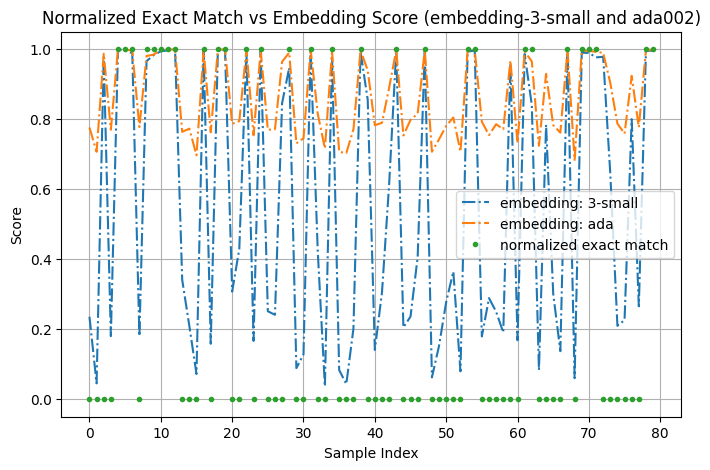

In [6]:
plt.figure(figsize=(8,5))

plt.plot(small_3_scores, '-.', label="embedding: 3-small")
plt.plot(ada_scores, '-.', label="embedding: ada")
plt.plot(labels, '.', label="normalized exact match")

plt.title('Normalized Exact Match vs Embedding Score (embedding-3-small and ada002)')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


### 3. 我們來直接基於某個 threshold 看 precision 跟 recall

In [7]:
import evaluate  # pip install evaluate

def _get_binary_prediction(pred, thr):
    return [0.0 if p <= thr else 1. for p in pred]

def _get_precision_recall(pred, label):
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    combined = evaluate.combine([precision_metric, recall_metric])
    results = combined.compute(predictions=pred, references=label)
    return results  # dict 

def get_precision_recall(pred, label, thr):
    binary_pred = _get_binary_prediction(pred, thr)
    result = _get_precision_recall(binary_pred, label)
    return result  # dict 

/home/poyuan/miniconda3/envs/rag30/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
threshold = 0.8557835443653601
print("# small-3 result: ")
print(get_precision_recall(small_3_scores, labels, threshold))
print("# ada result: ")
print(get_precision_recall(ada_scores, labels, threshold))


# small-3 result: 
{'precision': 0.9032258064516129, 'recall': 0.9655172413793104}
# ada result: 
{'precision': 0.7631578947368421, 'recall': 1.0}


In [9]:
threshold = 0.9676289405210952
print("# small-3 result: ")
print(get_precision_recall(small_3_scores, labels, threshold))
print("# ada result: ")
print(get_precision_recall(ada_scores, labels, threshold))


# small-3 result: 
{'precision': 0.9285714285714286, 'recall': 0.896551724137931}
# ada result: 
{'precision': 0.9333333333333333, 'recall': 0.9655172413793104}


# 4. 這個 threshold 怎麼來的?
- [理論]: 我們可以基於 pr-curve 來選擇
    - 首先把我們的 similarity score 由小排到大
    - 接著我們把每個 similarity score 當作 threshold，分別計算 precision, recall
    - 最後我們再插入 precision=1, recall=0 的起始點
        - 所以 precision, recall 會有 num_point + 1 個點

- [實作]: 我們這邊直接使用 sklearn 的 precision_recall_curve
    - input 是 pred_score(list of float) 以及 labels (list of 0/1)
    - output 是 precision, recalls, thresholds，都是 ndarray

In [10]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# 這邊算的是 ada-002 的結果

precisions, recalls, thresholds = precision_recall_curve(labels, ada_scores)
print(type(precisions), precisions.shape, type(recalls), recalls.shape, type(thresholds), thresholds.shape)

model_base_name = 'ada-002'
ap = average_precision_score(labels, ada_scores)
print(f'{model_base_name} ap: {ap}')

<class 'numpy.ndarray'> (81,) <class 'numpy.ndarray'> (81,) <class 'numpy.ndarray'> (80,)
ada-002 ap: 0.9920902695204122


In [11]:
# 這邊算的是 small-3 的結果，要用 ada-002 的結果就把這塊註解掉
precisions, recalls, thresholds = precision_recall_curve(labels, small_3_scores)
print(type(precisions), precisions.shape, type(recalls), recalls.shape, type(thresholds), thresholds.shape)

model_base_name = 'small-3'
ap = average_precision_score(labels, small_3_scores)
print(f'{model_base_name} ap: {ap}')


<class 'numpy.ndarray'> (81,) <class 'numpy.ndarray'> (81,) <class 'numpy.ndarray'> (80,)
small-3 ap: 0.9867507894569743


In [12]:
def average_precision_from_pr(precision, recall):
    """
    與 sklearn.average_precision_score 等價的 step integral（無平滑、無插值）
    接受 precision_recall_curve 的輸出 (precision, recall)
    """
    p = np.asarray(precision, dtype=float)
    r = np.asarray(recall, dtype=float)

    # 反轉成 recall 單調遞增
    if r.size >= 2 and r[0] > r[-1]:
        p = p[::-1]
        r = r[::-1]

    # 階梯積分（右端點）：sum( (r[i]-r[i-1]) * p[i] ), i=1..n-1
    dr = np.diff(r)
    ap = float(np.sum(dr * p[1:]))
    return ap

ap = average_precision_from_pr(precisions, recalls)
print(f'small_3 ap: {ap}')

small_3 ap: 0.9867507894569741


In [13]:
# 同時我們可以基於每一個點的 precision 以及 recall 計算 f1-score, 有多少個 precision, recall 對，我們就會有多少個 f1 score
def get_f1_score(precisions, recalls):
    # from precision and recall
    f1_scores = np.where(
        (precisions + recalls) > 0,
        2 * precisions * recalls / (precisions + recalls),
        0.0,
    )
    return f1_scores

f1_scores = get_f1_score(precisions, recalls)
f1_scores.shape

(81,)

In [14]:
# 我們挑選 top-3 的 f1 score 作為 highlight
def get_topk_highlight(precisions, recalls, k=3):
    f1_scores = get_f1_score(precisions, recalls)
    topk_idx = np.argsort(-f1_scores)[:k]

    highlights = []
    for idx in topk_idx:
        thr = None if idx == 0 else thresholds[idx - 1]
        highlights.append({
            "f1": float(f1_scores[idx]),
            "precision": float(precisions[idx]),
            "recall": float(recalls[idx]),
            "threshold": None if thr is None else float(thr),
            "idx": int(idx),
        })
    return highlights

highlights = get_topk_highlight(precisions, recalls)
highlights

[{'f1': 0.9333333333333333,
  'precision': 0.9032258064516129,
  'recall': 0.9655172413793104,
  'threshold': 0.8557835443653601,
  'idx': 49},
 {'f1': 0.9310344827586207,
  'precision': 0.9310344827586207,
  'recall': 0.9310344827586207,
  'threshold': 0.9590037697607575,
  'idx': 51},
 {'f1': 0.9259259259259259,
  'precision': 1.0,
  'recall': 0.8620689655172413,
  'threshold': 0.9783290764981016,
  'idx': 55}]

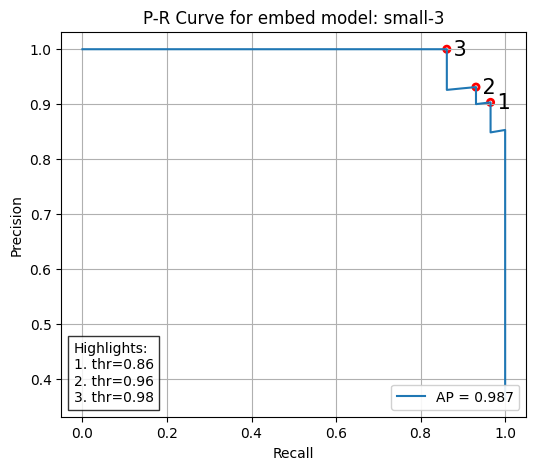

In [15]:
# 繪圖
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f"AP = {ap:.3f}")

# highlight 點只標號碼
for i, h in enumerate(highlights, 1):
    plt.scatter(h["recall"], h["precision"],
                s=20, facecolors="none", edgecolors="red", linewidths=2)
    plt.text(h["recall"], h["precision"], f"    {i}",
             fontsize=15, ha="center", va="center", color="black")

# thresholds 說明，放左下角
thr_lines = [f"{i}. thr={h['threshold']:.2f}" for i, h in enumerate(highlights, 1)]
txt = "Highlights:\n" + "\n".join(thr_lines)
at = AnchoredText(txt, prop=dict(size=10), frameon=True, loc="lower left")
at.patch.set_alpha(0.8)
plt.gca().add_artist(at)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"P-R Curve for embed model: {model_base_name}")
plt.legend(loc="lower right", framealpha=0.9)  # 這裡只放 AP
plt.grid(True)
plt.show()
